# TBD - PROJEKT 2 - ZESPÓŁ 12

## Autorzy
- Aleksander Bujnowski
- Bartłomiej Krajewski
- Krzysztof Kluczyński

## Cel projektu

Celem zadania było rozszerzenie biblioteki `polars-bio` o nową funkcję kontroli jakości _k-mer quantities_, której celem jest analiza częstości występowania k-merów w plikach FASTQ. Implementacja została zrealizowana w języku Rust jako funkcja agregująca (UDAF) dostępna z poziomu Pythona przez interfejs SQL.

## Zakres sprawozdania

Sprawozdanie poruszać będzie następujące kwestie:

- **Opis implmentacji**
- **Opis funkcjonalności** `kmer_count(sequence, k)`
- **Wizualizacja danych wyjściowych**
- **Testy poprawności działania**
- **Pomiar wydajności**

## Import bibliotek

In [ ]:
import polars_bio as pb
from polars_bio.io import read_fastq

INFO:polars_bio:Creating BioSessionContext


## Opis implementacji

Przygotowana funkcja nosi nazwę `kmer_count`, została zaimplementowana jako UDAF służąca do zliczania kanonicznych k-merów w sekwencjach DNA. Wykorzystuje strukturę `Accumulator`, która przechowuje słownik k-merów oraz ich liczności, wyznaczając dla każdego fragmentu sekwencji jego formę kanoniczną. Funkcja zapewnia spójność parametru k i obsługuje łączenie wyników z wielu partycji. Implementacja znajduje się w pliku `kmers_udaf.rs`, a rejestracja UDAF została dodana w `context.rs`, co umożliwia jej użycie w zapytaniach SQL.

## Opis funkcjonalności

Zaimplementowana funkcjonalność dostępna jest jako funkcja agregująca w SQL: `kmer_count(sequence, k)`. Funkcja ta analizuje kolumnę z sekwencjami DNA (np. `sequence`) i zwraca zliczenia wszystkich k-merów (fragmentów długości `k`) w ich kanonicznej postaci.

Po wykonaniu operacji `.collect()` otrzymujemy jedną kolumnę typu struct, zawierającą pary {kmer, count}, czyli kanoniczne k-mery oraz liczbę ich wystąpień w danych wejściowych.

Przykładowe wywołanie na danych FASTQ wygląda następująco:

In [ ]:
df = read_fastq("example.fastq")
result = pb.sql("SELECT kmer_count(sequence, 3) FROM example").collect()
print(result)

INFO:polars_bio:Table: example registered for path: example.fastq


0rows [00:00, ?rows/s]

shape: (32, 1)
┌─────────────────────────────────┐
│ kmer_count(example.sequence,In… │
│ ---                             │
│ struct[2]                       │
╞═════════════════════════════════╡
│ {"AAT",635}                     │
│ {"AAA",1013}                    │
│ {"CGA",181}                     │
│ {"ACA",761}                     │
│ {"GCA",649}                     │
│ …                               │
│ {"GCC",595}                     │
│ {"CTC",791}                     │
│ {"AAC",494}                     │
│ {"ACT",574}                     │
│ {"CAA",670}                     │
└─────────────────────────────────┘


## Wizualizacja danych wyjściowych
W celu graficznego przedstawienia wyników zliczania k-merów utworzona została funkcja `plot_kmer_counts(result, top_n)`. Funkcja ta generuje wykres słupkowy przedstawiający top_n najczęściej występujących k-merów (posortowanych malejąco według liczby wystąpień). 

Domyślnie wykres zwraca 20 k-merów, maksymalną wartością parametru `top_n` jest 100. W przypadku podania wartości większej niż liczba dostępnych unikalnych k-merów, funkcja automatycznie dostosowuje się do danych i narysuje wszystkie dostępne k-mery.

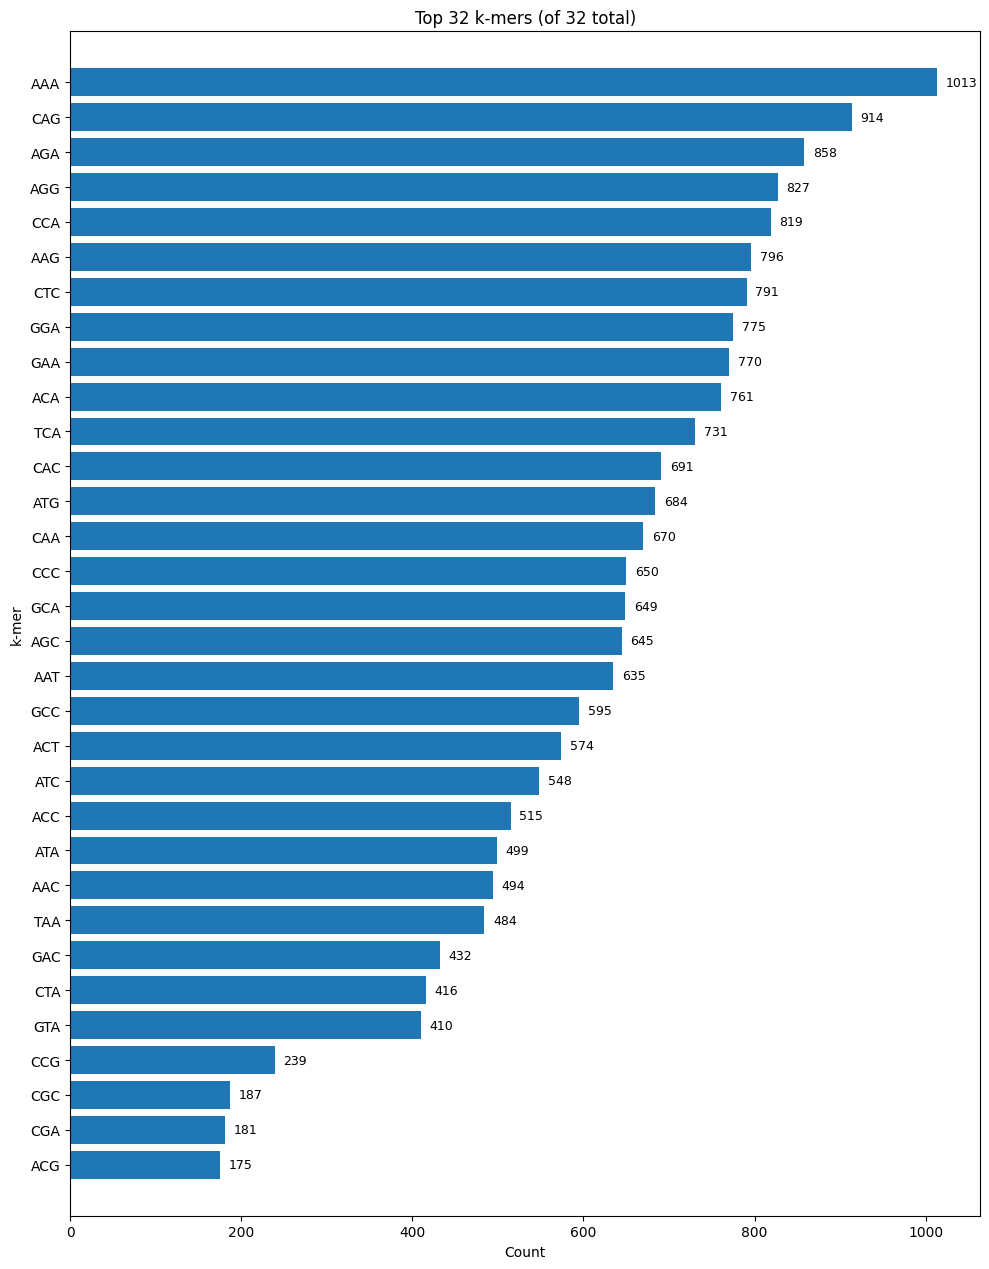

In [ ]:
pb.plot_kmer_counts(result, top_n=50)

## Testy poprawności działania

W celu zweryfikowania poprawności działania zaimplementowanej funkcji `kmer_count`, przygotowano zestaw testów jednostkowych opartych na danych referencyjnych wygenerowanych przy użyciu biblioteki `fastqc-rs`.

### Dane referencyjne

Wyniki działania narzędzia `fastqc-rs` zostały **ręcznie przekształcone do formatu `.json`**, zawierającego listę k-merów i odpowiadających im zliczeń. Pliki te znajdują się w katalogu `fastqc-rs_output` i są używane jako źródło prawdy do walidacji wyników.

### Testy jednostkowe

W pliku `tests/test_kmer_count.py` znajdują się testy, które sprawdzają:

- Poprawność wyników dla:
  - `k = 3`
  - `k = 5`
Porównanie odbywa się przez sortowanie i porównanie zawartości DataFrame’ów.

- Obsługę błędów dla niepoprawnego parametru k

- Walidację parametru `top_n` w funkcji wizualizującej (`plot_kmer_counts`) — test sprawdza, że dla `top_n > 100` zwracany jest wyjątek.

Testy można uruchomić standardową komendą:

```bash
pytest tests/test_kmer_count.py
```

## Pomiar wydajności

W celu porównania szybkości działania naszej implementacji (`polars_bio`) z biblioteką referencyjną `fastqc-rs`, przeprowadzono pomiar czasu wykonania dla obu podejść.

Dla polars_bio pomiar odbywa się z wykorzystaniem timera Pythona (`time.time()`). W przypadku fastqc-rs uruchamiamy polecenie w systemie operacyjnym z użyciem `subprocess.run(...)`

### Zbiory testowe
Wydajność została zmierzona na trzech różnych plikach FASTQ:
| Plik              | Rozmiar  |
| ----------------- | -------- |
| `example.fastq`   | \~50 KB  |
| `ERR194147_small.fastq` | \~700 MB |
| `ERR194147.fastq` | \~2 GB   |

INFO:polars_bio:Table: example registered for path: example.fastq



--- Benchmarking: example.fastq (50KB) ---


0rows [00:00, ?rows/s]

[polars_bio] example.fastq → 0.138 sec
[fastqc-rs]  example.fastq → 1.145 sec


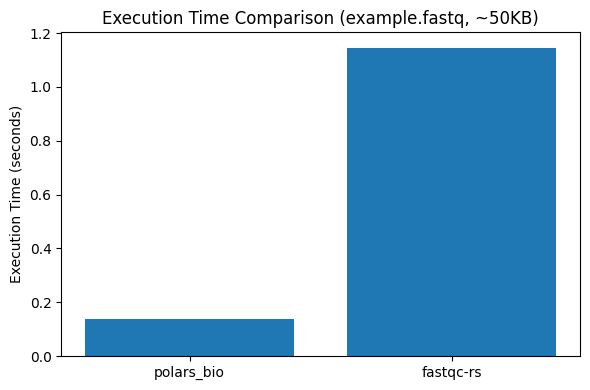

INFO:polars_bio:Table: err194147_small registered for path: ERR194147_small.fastq



--- Benchmarking: ERR194147_small.fastq (700MB) ---


0rows [00:00, ?rows/s]

[polars_bio] ERR194147_small.fastq → 31.949 sec
[fastqc-rs]  ERR194147_small.fastq → 12.962 sec


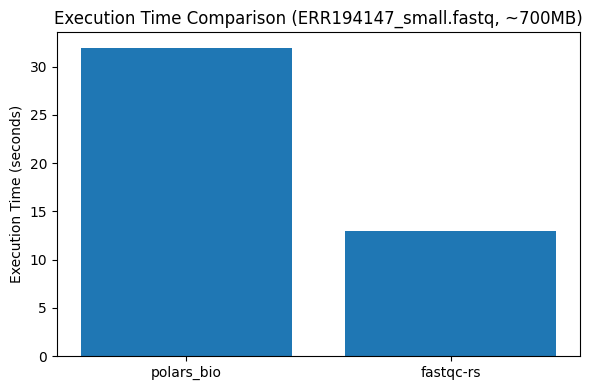

INFO:polars_bio:Table: err194147 registered for path: ERR194147.fastq



--- Benchmarking: ERR194147.fastq (2GB) ---


0rows [00:00, ?rows/s]

[polars_bio] ERR194147.fastq → 100.770 sec
[fastqc-rs]  ERR194147.fastq → 35.600 sec


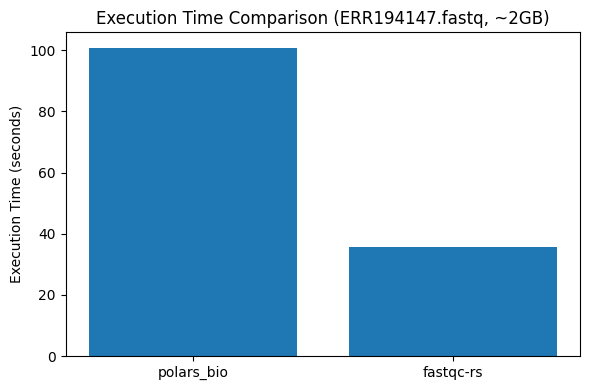

In [ ]:
import time
import subprocess
import matplotlib.pyplot as plt

datasets = [
    ("example.fastq", "50KB"),
    ("ERR194147_small.fastq", "700MB"),
    ("ERR194147.fastq", "2GB"),
]

for file_name, size_label in datasets:
    print(f"\n--- Benchmarking: {file_name} ({size_label}) ---")

    df = read_fastq(file_name)
    start_my = time.time()
    pb.sql(f"SELECT kmer_count(sequence, 5) AS result FROM {file_name.split('.')[0]}").collect()
    end_my = time.time()
    time_polars = end_my - start_my
    print(f"[polars_bio] {file_name} → {time_polars:.3f} sec")

    start_fastqc = time.time()
    subprocess.run(
        ["fqc", "-q", file_name, "-k", "5"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
        check=True
    )
    end_fastqc = time.time()
    time_fastqc = end_fastqc - start_fastqc
    print(f"[fastqc-rs]  {file_name} → {time_fastqc:.3f} sec")

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(["polars_bio", "fastqc-rs"], [time_polars, time_fastqc])
    ax.set_ylabel("Execution Time (seconds)")
    ax.set_title(f"Execution Time Comparison ({file_name}, ~{size_label})")

    plt.tight_layout()
    plt.show()

## Podsumowanie

Testy potwierdziły, że funkcja count_kmer działa poprawnie i zwraca oczekiwane wyniki. Mimo to, wydajność naszej implementacji nie jest jeszcze w pełni satysfakcjonująca. Dla małego pliku wejściowego (50 KB) nasze rozwiązanie działa szybciej niż fastqc-rs, co może wynikać z faktu, że fastqc-rs dodatkowo odczytuje plik i generuje raport HTML. Dla większego pliku (700 MB) fastqc-rs osiąga już lepsze wyniki, natomiast przy pliku 2 GB rezultat jest zdecydowanie lepszy dla fastqc-rs. Różnice w wydajności mogą wynikać m.in. z nieoptymalnej implementacji oraz nieefektywnego wykorzystania struktur danych. Dodatkowo, implementacja oparta na DataFusion może nie wykorzystywać w pełni możliwości równoległego przetwarzania, co skutkuje niedostatecznym rozproszeniem danych i niewykorzystaniem potencjału systemu wieloprocesorowego. Pokazuje to, że nasza metoda wciąż może zostać znacząco zoptymalizowana zarówno na poziomie algorytmicznym, jak i infrastrukturalnym.








